In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###download the F3 dataset from the google drive
# !gdown 'https://drive.google.com/uc?export=download&id=1cCQis-CMm8s564l3sAmcMocJShrEqwXZ'

Downloading...
From: https://drive.google.com/uc?export=download&id=1cCQis-CMm8s564l3sAmcMocJShrEqwXZ
To: /content/drive/Othercomputers/My Computer/DIssertation Research/F3_entire.segy
100% 1.29G/1.29G [00:35<00:00, 36.1MB/s]


In [ ]:
# !unzip F3_Demo_2020.zip -d F3_Dataset

In [2]:
cd ./drive/MyDrive/Seismic_Data_Segy

/content/drive/MyDrive/Seismic_Data_Segy


In [1]:
!pip install segyio

     |████████████████████████████████| 83 kB 1.1 MB/s eta 0:00:01


In [5]:
import os
import segyio
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as im
import imageio
import cv2

ModuleNotFoundError: No module named 'cv2'

## Prepare data for training diffusion model

In [ ]:
filename = 'F3_entire.segy'
inlines = []
with segyio.open(filename, "r") as segyfile:

    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()

    for inline in segyfile.ilines:
        inlines.append(segyfile.iline[inline])

# abs_max = np.max(np.abs(inlines))
# scale = 1.0/(2.0*abs_max)

f3_inlines = np.array(inlines)
# inlines = inlines*factor
# inlines = 2*((inlines - np.min(inlines)) / (np.max(inlines) - np.min(inlines)))-1
# slice_segy = (inlines.T.clip(-abs_max, abs_max) + abs_max)*scale

print(f3_inlines.shape)

paritrain = np.load('./Labeled_Facies/Parihaka/data_train.npz')
paritrain = paritrain['data']
paritrain=np.transpose(paritrain, (1, 2, 0))
print(paritrain.shape)

(651, 951, 462)
(782, 590, 1006)


In [ ]:
f3_clean1 = f3_inlines[:601,:,206:]
f3_clean2 = f3_inlines[601:,400:900,206:]

In [ ]:
f3_clean1.shape

(601, 951, 256)

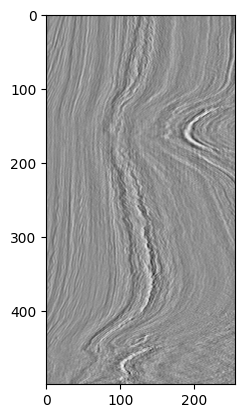

In [ ]:
plt.imshow(f3_clean2[1,:,:], cmap='Greys')

In [ ]:
# plt.imshow(slice_segy[400,:,:], cmap='Greys')

In [ ]:
def crop_and_save_images(data, output_directory, seismic_name = '',type='seismic', crop_size=256):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    min_value = np.min(data)
    max_value = np.max(data)
    data = 256 * (data - min_value) / (max_value - min_value)
    data = data.astype(np.uint8)

    patch_no=0
    x_ax, y_ax, z_ax = data.shape
    for x in range(0, x_ax):
        sliced_data = data[x, :, :]
        for z in range(0, z_ax, crop_size):
            for y in range(0, y_ax, crop_size):
                cropped_data = sliced_data[y:y+crop_size, z:z+crop_size]
                if cropped_data.shape == (crop_size, crop_size):
                    image_path = os.path.join(output_directory, f'{seismic_name}_{x}_{y}_{z}.jpg')
                    imageio.imwrite(image_path, cropped_data)
                    patch_no+=1

        if x%100 == 0:
            print(f"Saved {x} inlines as patches")
    print(f"Total of {x} inlines saved as patches")
    ##overlap to not loose information at the edge
    print('--------------')
    print('Working on the edge patches')
    for x in range(0, x_ax):
        sliced_data = data[x, :, :]
        for z in range(z_ax-crop_size, z_ax-crop_size-1, -crop_size):
            for y in range(y_ax-crop_size, y_ax-crop_size-1, -crop_size):
                cropped_data = sliced_data[y:y+crop_size, z:z+crop_size]
                if cropped_data.shape == (crop_size, crop_size):
                    image_path = os.path.join(output_directory, f'{seismic_name}-overlap_{y_ax%crop_size}_{z_ax%crop_size}_{x}_{y}_{z}.jpg')
                    imageio.imwrite(image_path, cropped_data)
                    patch_no+=1
    print('Patches done!!!')
    print(f'{patch_no} patches saved')
    print('---------------------------')

In [ ]:
output_directory = './data_patches/diffusion_data'
crop_and_save_images(f3_clean1, output_directory,seismic_name = 'F3_clean1',type='seismic')
crop_and_save_images(f3_clean2, output_directory,seismic_name = 'F3_clean2',type='seismic')
crop_and_save_images(paritrain, output_directory,seismic_name = 'Pari',type='seismic')

Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Saved 600 inlines as patches
Total of 600 inlines saved as patches
--------------
Working on the edge patches
Patches done!!!
2404 patches saved
---------------------------
Saved 0 inlines as patches
Total of 49 inlines saved as patches
--------------
Working on the edge patches
Patches done!!!
100 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Saved 600 inlines as patches
Saved 700 inlines as patches
Total of 781 inlines saved as patches
--------------
Working on the edge patches
Patches done!!!
5474 patches saved
---------------------------


---
## Segmentation training and testing data

In [ ]:
cd ./drive/MyDrive/Seismic_Data_Segy

/content/drive/MyDrive/Seismic_Data_Segy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

In [ ]:
def crop_and_save_images(data, output_directory, seismic_name = '',type='seismic', crop_size=256):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    if type == 'seismic':
        min_value = np.min(data)
        max_value = np.max(data)
        data = 256 * (data - min_value) / (max_value - min_value)
        data = data.astype(np.uint8)

        patch_no=0
        x_ax, y_ax, z_ax = data.shape
        for x in range(0, x_ax):
            sliced_data = data[x, :, :]
            for z in range(0, z_ax, crop_size):
                for y in range(0, y_ax, crop_size):
                    cropped_data = sliced_data[y:y+crop_size, z:z+crop_size]
                    if cropped_data.shape == (crop_size, crop_size):
                        image_path = os.path.join(output_directory, f'{seismic_name}_{x}_{y}_{z}.jpg')
                        imageio.imwrite(image_path, cropped_data)
                        patch_no+=1
            #overlap to not loose information at the edge
            if z_ax%crop_size > 0:
                for y in range(0, y_ax, crop_size):
                    cropped_data = sliced_data[y:y+crop_size, -crop_size:]
                    if cropped_data.shape == (crop_size, crop_size):
                        image_path = os.path.join(output_directory, f'{seismic_name}-overlap_{x}_{y}_{z_ax-z_ax%crop_size}_{y_ax}_{z_ax}.jpg')
                        imageio.imwrite(image_path, cropped_data)
                        patch_no+=1
            if y_ax%crop_size > 0:
                for z in range(0, z_ax, crop_size):
                    cropped_data = sliced_data[ -crop_size:, z:z+crop_size]
                    if cropped_data.shape == (crop_size, crop_size):
                        image_path = os.path.join(output_directory, f'{seismic_name}-overlap_{x}_{y_ax-y_ax%crop_size}_{z}_{y_ax}_{z_ax}.jpg')
                        imageio.imwrite(image_path, cropped_data)
                        patch_no+=1
            if y_ax%crop_size > 0 and z_ax%crop_size > 0:
                cropped_data = sliced_data[-crop_size:, -crop_size:]
                if cropped_data.shape == (crop_size, crop_size):
                    image_path = os.path.join(output_directory, f'{seismic_name}-overlap_{x}_{y_ax-y_ax%crop_size}_{z_ax-z_ax%crop_size}_{y_ax}_{z_ax}.jpg')
                    imageio.imwrite(image_path, cropped_data)
                    patch_no+=1

            if x%100 == 0:
                print(f"Saved {x+1} inlines as patches")

        print('Patches done!!!')
        print(f"{x+1} inlines saved as patches")
        print(f'{patch_no} patches saved')
        print('---------------------------')

    elif type == 'label':
        patch_no=0
        x_ax, y_ax, z_ax = data.shape
        for x in range(0, x_ax):
            sliced_data = data[x, :, :]
            for z in range(0, z_ax, crop_size):
                for y in range(0, y_ax, crop_size):
                    cropped_data = sliced_data[y:y+crop_size, z:z+crop_size]
                    if cropped_data.shape == (crop_size, crop_size):
                        label_path = os.path.join(output_directory, f'{seismic_name}_{x}_{y}_{z}.npy')
                        np.save(label_path, cropped_data)
                        patch_no+=1
            #overlap to not loose information at the edge
            if z_ax%crop_size > 0:
                for y in range(0, y_ax, crop_size):
                    cropped_data = sliced_data[y:y+crop_size, -crop_size:]
                    if cropped_data.shape == (crop_size, crop_size):
                        label_path = os.path.join(output_directory, f'{seismic_name}-overlap_{x}_{y}_{z_ax-z_ax%crop_size}_{y_ax}_{z_ax}.npy')
                        np.save(label_path, cropped_data)
                        patch_no+=1
            if y_ax%crop_size > 0:
                for z in range(0, z_ax, crop_size):
                    cropped_data = sliced_data[ -crop_size:, z:z+crop_size]
                    if cropped_data.shape == (crop_size, crop_size):
                        label_path = os.path.join(output_directory, f'{seismic_name}-overlap_{x}_{y_ax-y_ax%crop_size}_{z}_{y_ax}_{z_ax}.npy')
                        np.save(label_path, cropped_data)
                        patch_no+=1
            if y_ax%crop_size > 0 and z_ax%crop_size > 0:
                cropped_data = sliced_data[-crop_size:, -crop_size:]
                if cropped_data.shape == (crop_size, crop_size):
                    label_path = os.path.join(output_directory, f'{seismic_name}-overlap_{x}_{y_ax-y_ax%crop_size}_{z_ax-z_ax%crop_size}_{y_ax}_{z_ax}.npy')
                    np.save(label_path, cropped_data)
                    patch_no+=1

            if x%100 == 0:
                print(f"Saved {x+1} inlines as patches")

        print('Patches done!!!')
        print(f"{x+1} inlines saved as patches")
        print(f'{patch_no} patches saved')
        print('---------------------------')

In [ ]:
#F3 labeled data

f3train = np.load('./Labeled_Facies/F3/train/train_seismic.npy')
n = f3train.shape
f3train = np.concatenate((f3train, f3train[:,:,-1].reshape(n[0],n[1],1)), axis=2)

f3train_label = np.load('./Labeled_Facies/F3/train/train_labels.npy')
f3train_label = np.concatenate((f3train_label, f3train_label[:,:,-1].reshape(n[0],n[1],1)), axis=2)

f3test1 = np.load('./Labeled_Facies/F3/test_once/test1_seismic.npy')
n = f3test1.shape
f3test1 = np.concatenate((f3test1, f3test1[:,:,-1].reshape(n[0],n[1],1)), axis=2)

f3test1_label = np.load('./Labeled_Facies/F3/test_once/test1_labels.npy')
f3test1_label = np.concatenate((f3test1_label, f3test1_label[:,:,-1].reshape(n[0],n[1],1)), axis=2)

# f3test2 = np.load('./Labeled_Facies/F3/test_once/test2_seismic.npy')
# n = f3test2.shape
# f3test2 = np.concatenate((f3test2, f3test2[:,:,-1].reshape(n[0],n[1],1)), axis=2)

# f3test2_label = np.load('./Labeled_Facies/F3/test_once/test2_labels.npy')
# f3test2_label = np.concatenate((f3test2_label, f3test2_label[:,:,-1].reshape(n[0],n[1],1)), axis=2)

In [ ]:
#join test and train together
f3 = np.concatenate((f3test1,f3train))
f3label = np.concatenate((f3test1_label,f3train_label))

In [ ]:
n = f3.shape[0]

training_lines = np.linspace(0, n-1, 10, dtype=int)
f3train_lines_n = f3[training_lines,:,:]
f3train_label_lines_n = f3label[training_lines,:,:]

In [27]:
pari = np.load('./Labeled_Facies/Parihaka/data_train.npz')
pari = pari['data']
pari=np.transpose(pari, (1, 2, 0))

parilabel = np.load('./Labeled_Facies/Parihaka/labels_train.npz')
parilabel = parilabel['labels']
parilabel = parilabel - 1
parilabel = np.transpose(parilabel, (1, 2, 0))

paritrain = pari[0:501,:,:]
paritest = pari[501:,:,:]

parilabeltrain = parilabel[0:501,:,:]
parilabeltest = parilabel[501:,:,:]

In [ ]:
n = paritrain.shape[0]

training_lines = np.linspace(0, n-1, 10, dtype=int)
paritrain_lines = paritrain[training_lines,:,:]
parilabeltrain_lines = parilabeltrain[training_lines,:,:]

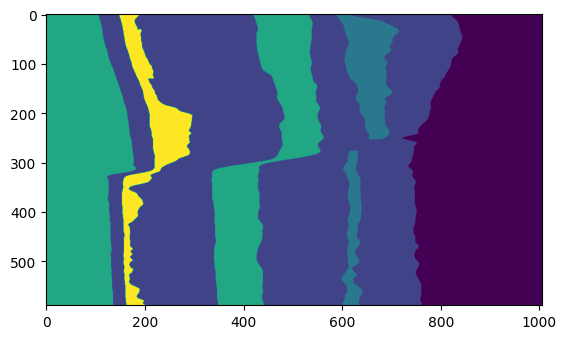

In [ ]:
plt.imshow(parilabeltrain[1])

In [17]:
#return 10 equally spaced inline
n = pari.shape[0]

training_lines = np.linspace(0, n-1, 10, dtype=int)
paritrain_lines = pari[training_lines]
paritest_lines = np.delete(pari, training_lines, axis=0)
parilabeltrain_lines = parilabel[training_lines]
parilabeltest_lines = np.delete(parilabel, training_lines, axis=0)

n = f3.shape[0]

training_lines = np.linspace(0, n-1, 10, dtype=int)
f3train_lines = f3[training_lines]
f3test_lines = np.delete(f3, training_lines, axis=0)
f3labeltrain_lines = f3label[training_lines]
f3labeltest_lines = np.delete(f3label, training_lines, axis=0)

In [20]:
#save F3 seismic and labels for 10 lines training and testing
output_directory = './Training_Testing_Data/F3_train'
crop_and_save_images(f3train_lines, output_directory,seismic_name = 'F3train',type='seismic')
crop_and_save_images(f3labeltrain_lines, output_directory,seismic_name = 'F3train',type='label')

output_directory = './Training_Testing_Data/F3_test'
crop_and_save_images(f3test_lines, output_directory,seismic_name = 'F3test',type='seismic')
crop_and_save_images(f3labeltest_lines, output_directory,seismic_name = 'F3test',type='label')

Saved 0 inlines as patches
Patches done!!!
9 inlines saved as patches
30 patches saved
---------------------------
Saved 0 inlines as patches
Patches done!!!
9 inlines saved as patches
30 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Patches done!!!
590 inlines saved as patches
1773 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Patches done!!!
590 inlines saved as patches
1773 patches saved
---------------------------


In [322]:
##save full dataset with original train_test split
output_directory = './labeled_data/F3_train'
crop_and_save_images(f3train, output_directory,seismic_name = 'F3train',type='seismic')
crop_and_save_images(f3train_label, output_directory,seismic_name = 'F3train',type='label')

output_directory = './labeled_data/F3_test1'
crop_and_save_images(f3test1, output_directory,seismic_name = 'F3test',type='seismic')
crop_and_save_images(f3test1_label, output_directory,seismic_name = 'F3test',type='label')

# output_directory = './data_patches/F3_test2'
# crop_and_save_images(f3test2, output_directory,seismic_name = 'F3test2seismic',type='seismic')
# crop_and_save_images(f3test2_label, output_directory,seismic_name = 'F3test2label',type='label')

Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Patches done!!!
400 inlines saved as patches
1203 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Patches done!!!
400 inlines saved as patches
1203 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Patches done!!!
199 inlines saved as patches
600 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Patches done!!!
199 inlines saved as patches
600 patches saved
---------------------------


In [21]:
#save Pari seismic and labels for 10 lines training and testing
output_directory = './Training_Testing_Data/Pari_train'
crop_and_save_images(paritrain_lines, output_directory,seismic_name = 'Paritrain',type='seismic')
crop_and_save_images(parilabeltrain_lines, output_directory,seismic_name = 'Paritrain',type='label')

output_directory = './Training_Testing_Data/Pari_test'
crop_and_save_images(paritest_lines, output_directory,seismic_name = 'Paritest',type='seismic')
crop_and_save_images(parilabeltest_lines, output_directory,seismic_name = 'Paritest',type='label')

Saved 0 inlines as patches
Patches done!!!
9 inlines saved as patches
120 patches saved
---------------------------
Saved 0 inlines as patches
Patches done!!!
9 inlines saved as patches
120 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Saved 600 inlines as patches
Saved 700 inlines as patches
Patches done!!!
771 inlines saved as patches
9264 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Saved 600 inlines as patches
Saved 700 inlines as patches
Patches done!!!
771 inlines saved as patches
9264 patches saved
---------------------------


In [323]:
##save full dataset with original train_test split
output_directory = './labeled_data/Pari/train'
crop_and_save_images(paritrain, output_directory,seismic_name = 'Paritrain',type='seismic')
crop_and_save_images(parilabeltrain, output_directory,seismic_name = 'Paritrain',type='label')

output_directory = './labeled_data/Pari/test'
crop_and_save_images(paritest, output_directory,seismic_name = 'Paritest',type='seismic')
crop_and_save_images(parilabeltest, output_directory,seismic_name = 'Paritest',type='label')

Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Patches done!!!
500 inlines saved as patches
6012 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Saved 300 inlines as patches
Saved 400 inlines as patches
Saved 500 inlines as patches
Patches done!!!
500 inlines saved as patches
6012 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Patches done!!!
280 inlines saved as patches
3372 patches saved
---------------------------
Saved 0 inlines as patches
Saved 100 inlines as patches
Saved 200 inlines as patches
Patches done!!!
280 inlines saved as patches
3372 patches saved
---------------------------
